
Procesando 4 imágenes aleatorias.

[1/4] Procesando: 1734589666775.tif


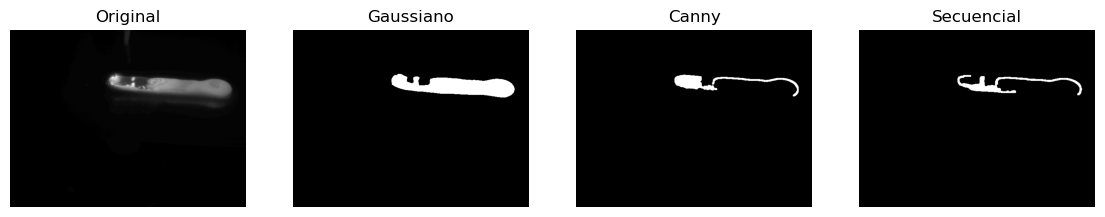

<Figure size 640x480 with 0 Axes>

[2/4] Procesando: 1734589593260.tif


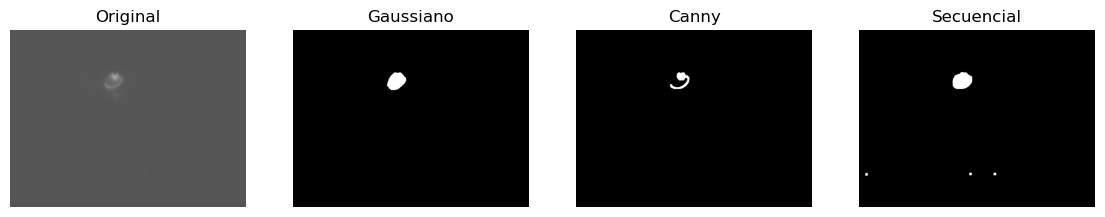

<Figure size 640x480 with 0 Axes>

[3/4] Procesando: 1734589667770.tif


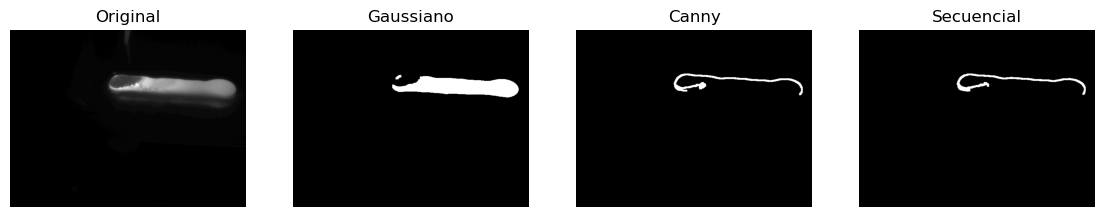

<Figure size 640x480 with 0 Axes>

[4/4] Procesando: 1734589599550.tif


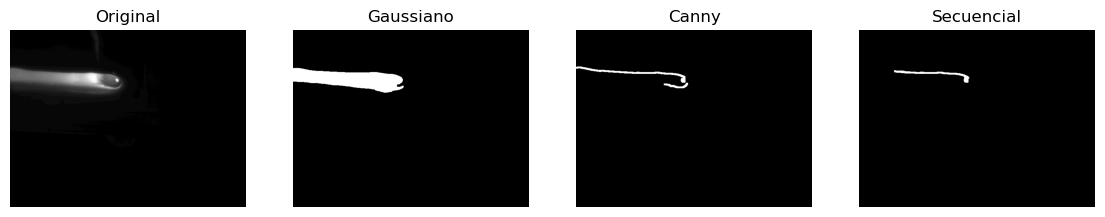

<Figure size 640x480 with 0 Axes>


Proceso completado.


In [6]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Configuración Train Test
images_path = '/Documentos Maestria/Procesamiento de Imagen y Señales MIA-B (Materia 1)/VSC semana3/Data'
dataset_path = '/Documentos Maestria/Procesamiento de Imagen y Señales MIA-B (Materia 1)/VSC semana3/Dataset'

test_dir = '/Documentos Maestria/test'
train_dir = '/Documentos Maestria/traint'
os.makedirs(train_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)

images = os.listdir(images_path)

train_images, test_images = train_test_split(images, train_size=0.8, random_state=42)

for file in train_images:
    shutil.copy2(os.path.join(images_path, file), os.path.join(train_dir,file))

for file in test_images:
    shutil.copy2(os.path.join(images_path, file), os.path.join(test_dir,file))


# Creación métodos de segmentación
# Realiza Segmentación basada en suavizado gaussiano(reducción de ruido),
# Umbralización con otsu
# Operacion morfologica (apertura y cierre)

def metodo_gaussiano(img):
    #suavizado para eliminar ruido
    blur = cv2.GaussianBlur(img, (5,5), 0)
    # Umbralización automática usando el método Otsu
    # THRESH_BINARY convierte la imagen en binaria (0 o 255)
    # THRESH_OTSU calcula automáticamente el mejor umbral
    _, thresh = cv2.threshold(blur, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # creamos kernel para operaciones morfologicas
    kernel = np.ones((5,5), np.uint8)
    # Apertura morfológica (erosión seguida de dilatación)
    # Elimina pequeñas regiones de ruido blanco
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    #Cierre morfológico (dilatacion seguida de erosión)
    # rellena pequeños huecos dentro del objeto segmentado
    return cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# Segmentación basada en canny
# detección de bordes, filtro mediana, detecttor de bordes canny, dilatación para reforzar bordes
# , detección y relleno de contornos
def metodo_canny(img):
    median = cv2.medianBlur(img, 5)
    edges = cv2.Canny(median, 10, 50)
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(
        dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    result = np.zeros_like(img)
    cv2.drawContours(result, contours, -1, 255, thickness=cv2.FILLED)
    return result

# Segmentación secuencial
# Suavizado Gaussiano, Canny para obtener bordes, dilatación, construcción de masacara RIO,
# umbralización otsu sobre la ROI
def metodo_secuencial(img):
    # suavizado gaussiano
    blur = cv2.GaussianBlur(img, (5,5), 0)
    # detectamos los bordes
    edges = cv2.Canny(blur, 10, 50)
    # dilatación para fortalecer los bordes
    kernel_small = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(edges, kernel_small, iterations=2)
    # detectamos contornos externos
    contours, _ = cv2.findContours(
        dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # creamos mascara vacia
    mask = np.zeros_like(img)

    # rellenamos contornos en la mascara
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    # Extraemos la region de interes (ROI)
    roi = cv2.bitwise_and(img, img, mask=mask)

    # Aplicamos OTSU dentro de la región de interes
    _, otsu_roi = cv2.threshold(
        roi, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Cierre morfológico final para suavizar la región segmentada
    kernel_large = np.ones((5,5), np.uint8)
    return cv2.morphologyEx(otsu_roi, cv2.MORPH_CLOSE, kernel_large)



# Método que imprime imágenes


def imprimir_imagenes(original, r1, r2, r3, nombre):

    plt.figure(figsize=(14,4))

    plt.subplot(1,4,1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis("off")


    plt.subplot(1,4,2)
    plt.imshow(r1, cmap='gray')
    plt.title("Gaussiano")
    plt.axis("off")


    plt.subplot(1,4,3)
    plt.imshow(r2, cmap='gray')
    plt.title("Canny")
    plt.axis("off")


    plt.subplot(1,4,4)
    plt.imshow(r3, cmap='gray')
    plt.title("Secuencial")
    plt.axis("off")
    plt.show()

    plt.suptitle(f"Imagen: {nombre}")
    plt.tight_layout()
    plt.show()



# Aplicando con Train , luego mostramos las imagenes con las funciones creadas

def procesar_y_mostrar():

    images_train = os.listdir(train_dir)
    if len(images_train) > 4:
        images_train = random.sample(images_train, 4)

    total = len(images_train)

    print("\nProcesando 4 imágenes aleatorias.\n")

    for i, file_name in enumerate(images_train):

        print(f"[{i+1}/{total}] Procesando: {file_name}")

        img_path = os.path.join(train_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        # Aplicar métodos
        r1 = metodo_gaussiano(img)
        r2 = metodo_canny(img)
        r3 = metodo_secuencial(img)       

        # Mostrar imágenes
        imprimir_imagenes(img, r1, r2, r3, file_name)

    print("\nProceso completado.")



# Ejecución metodo procesar y mostrar imágenes


if __name__ == "__main__":
    procesar_y_mostrar()